# 图卷积网络 GCN

- PyG: [conv.GCNConv](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GCNConv.html#torch-geometric-nn-conv-gcnconv)
- arXiv: [Semi-Supervised Classification with Graph Convolutional Networks](https://arxiv.org/abs/1609.02907)
- GitHub: [tkipf/gcn](https://github.com/tkipf/gcn)

In [1]:
# !conda install pyg -c pyg

In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

import matplotlib.pyplot as plt

import util

In [3]:
CORA_PATH = './data'
EDGE_FILE = 'cora.cites'
FEAT_FILE = 'cora.content'

## 1. 加载数据的极简示例

PyG 用一个叫 `torch_geometric.data.Data` 的数据结构存储图数据，节点特征和节点关系都存在这个数据结构里。

In [4]:
edge_index = torch.tensor([[0, 1],
                           [1, 0],
                           [1, 2],
                           [2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index.t().contiguous())
data

Data(x=[3, 1], edge_index=[2, 4])

In [5]:
data.validate(raise_on_error=True)

True

In [6]:
lst = [
    f'data.keys(): {data.keys()}',
    f'data["edge_index"]: {data["edge_index"]}',
    f'data["x"]: {data["x"]}',
    f'data.num_nodes: {data.num_nodes}',
    f'data.num_edges: {data.num_edges}',
    f'data.num_node_features: {data.num_node_features}',
    f'data.has_isolated_nodes(): {data.has_isolated_nodes()}',
    f'data.has_self_loops(): {data.has_self_loops()}',
    f'data.is_directed(): {data.is_directed()}'
]
print('\n'.join(lst))

data.keys(): ['x', 'edge_index']
data["edge_index"]: tensor([[0, 1, 1, 2],
        [1, 0, 2, 1]])
data["x"]: tensor([[-1.],
        [ 0.],
        [ 1.]])
data.num_nodes: 3
data.num_edges: 4
data.num_node_features: 1
data.has_isolated_nodes(): False
data.has_self_loops(): False
data.is_directed(): False


## 2. 加载 Cora 数据集

In [7]:
def load_cora(edge_path, feat_path):
    """加载 cora 数据集

    :param edge_path: cora 数据集边文件 
    :param feat_path: cora 数据集节点特征文件

    :return node_to_noi: 节点到节点下标的字典
    :return noi_to_feat: 节点下标到节点特征的字典
    :return noi_to_label: 节点下标到节点标签的字典
    :return label_map: 节点标签值到节点标签的字典
    """
    # noi: node_index
    node_to_noi = dict()
    noi_to_feat = dict()
    noi_to_label = dict()
    label_map = dict()
    with open(feat_path) as fp:
        for i, line in enumerate(fp):
            info = line.strip().split()

            node_to_noi[info[0]] = i
            noi_to_feat[i] = [int(e) for e in info[1:-1]]
            if info[-1] not in label_map:
                label_map[info[-1]] = len(label_map)
            noi_to_label[i] = label_map[info[-1]]

    edge_list = list()
    with open(edge_path) as fp:
        for line in fp:
            info = line.strip().split()

            node_a = node_to_noi[info[0]]
            node_b = node_to_noi[info[1]]
            edge_list.append([node_a, node_b])

    return edge_list, noi_to_feat, noi_to_label, label_map

edge_path = util.gen_abspath(CORA_PATH, EDGE_FILE)
feat_path = util.gen_abspath(CORA_PATH, FEAT_FILE)
edge_list, feat_dict, label_dict, label_map = load_cora(edge_path, feat_path)

In [8]:
# 把 cora 数据集加载成 PyG data
def create_pyg_cora_data(edge_list, feat_dict, label_dict):
    edge_index = torch.tensor(edge_list, dtype=torch.long)

    feat_list = [f[1] for f in sorted(feat_dict.items(), key=lambda e: e[0])]
    label_list = [l[1] for l in sorted(label_dict.items(), key=lambda e: e[0])]
    x = torch.tensor(feat_list, dtype=torch.float)
    y = torch.tensor(label_list, dtype=torch.long)

    return Data(x=x, y=y, edge_index=edge_index.t().contiguous())

cora_data = create_pyg_cora_data(edge_list, feat_dict, label_dict)
cora_data

Data(x=[2708, 1433], edge_index=[2, 5429], y=[2708])

In [9]:
# 随机分割训练集、验证集和测试集
def random_split_cora_data(data, train_rate, val_rate):
    assert train_rate + val_rate < 1
    N = data.num_nodes

    # 样本量
    num_train = int(N * train_rate)
    num_val = int(N * val_rate)
    num_test = N - num_train - num_val

    # 掩码初始化
    train_mask = torch.zeros(N, dtype=torch.bool)
    val_mask = torch.zeros(N, dtype=torch.bool)
    test_mask = torch.zeros(N, dtype=torch.bool)

    # 索引随机化
    perm = torch.randperm(N)

    # 按样本量分割数据集
    train_mask[perm[:num_train]] = True
    val_mask[perm[num_train:num_train+num_val]] = True
    test_mask[perm[num_train+num_val:]] = True

    # 将掩码添加到 data
    data.train_mask = train_mask
    data.val_mask = val_mask
    data.test_mask = test_mask

    return data

cora_dataset = random_split_cora_data(data=cora_data,
                                      train_rate=0.6,
                                      val_rate=0.2)

## 3. 训练 GCN 模型

训练一个有监督的节点分类模型，真实的标号存在 `cora_data.y` 里。用两层的 `GCNConv` 连接特征与标号。

In [10]:
class GCN(torch.nn.Module):

    def __init__(self, data, hidden_channels):
        super().__init__()
        num_classes = len({e.item() for e in data.y})
        self.conv1 = GCNConv(data.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

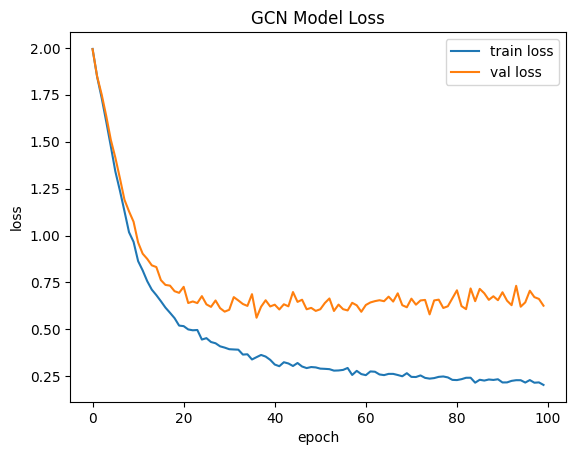

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(data=cora_data, hidden_channels=16).to(device)
data = cora_dataset.to(device)
optimizer = torch.optim.Adam(model.parameters(),
                             lr=0.01,
                             weight_decay=5e-4)



def train(model, optimizer, data, num_epoch):
    model.train()
    train_loss_list = list()
    val_loss_list = list()
    for epoch in range(num_epoch):
        optimizer.zero_grad()
        out = model(data)
        train_loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        train_loss.backward()
        optimizer.step()
        
        # 记录一下 train loss
        train_loss_list.append(train_loss.item())
    
        # 记录一下 validate loss
        val_loss = F.nll_loss(out[data.val_mask], data.y[data.val_mask])
        val_loss_list.append(val_loss.item())

    return model, train_loss_list, val_loss_list


def plot_loss(train_loss, val_loss, title):
    plt.plot(train_loss, label='train loss')
    plt.plot(val_loss, label='val loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title(title)
    plt.legend()
    plt.show()


model, train_loss_list, val_loss_list = train(model, optimizer, data, 100)
plot_loss(train_loss_list, val_loss_list, title='GCN Model Loss')

## 4. 预测与评估

In [12]:
# 用测试集做推理
out = model(data)
print(f'Embedding.shape of test dataset: {out[data.test_mask].shape}')
print(f'Top 5 Embedding of test dataset: {out[data.test_mask][:5]}')

# 标签到标签值的映射
reversed_label_map = {v:k for k, v in label_map.items()}

# 评估指标
model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = correct.item() / data.test_mask.sum().item()
print(f'Accuracy: {acc:.4f}')

# 打印前 5 个预测标签和真实标签
top_5_pred_label = [reversed_label_map[e.item()] for e in pred[data.test_mask][:5]]
top_5_true_label = [reversed_label_map[e.item()] for e in data.y[data.test_mask][:5]]
print(f'Top 5 pred label of test dataset: {top_5_pred_label}')
print(f'Top 5 true label of test dataset: {top_5_true_label}')

Embedding.shape of test dataset: torch.Size([543, 7])
Top 5 Embedding of test dataset: tensor([[ -5.9538,  -5.5722,  -6.6629,  -4.7706,  -2.3497,  -3.9169,  -0.1409],
        [ -7.9651,  -8.6054,  -3.4480, -12.6516,  -2.6534, -10.4734,  -0.1085],
        [-15.4338, -12.3045,  -0.0410, -13.6885,  -6.2233,  -5.4396,  -3.3862],
        [-11.9030, -11.0294,  -0.2839, -18.7023,  -2.1684,  -9.0234,  -2.0203],
        [ -1.2320,  -8.3128,  -5.8840,  -0.3624,  -4.7207,  -7.9902, -11.2466]],
       grad_fn=<SliceBackward0>)
Accuracy: 0.8711
Top 5 pred label of test dataset: ['Case_Based', 'Case_Based', 'Case_Based', 'Reinforcement_Learning', 'Neural_Networks']
Top 5 true label of test dataset: ['Case_Based', 'Case_Based', 'Reinforcement_Learning', 'Reinforcement_Learning', 'Neural_Networks']
